In [13]:
import os
import nibabel as nib
import scipy.io as sio
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn.glm.contrasts import compute_contrast

from utils.psth import map_events_to_frame_times, get_trial_data, normalize_data, proc_pixel

In [2]:
def get_task_idx(mat_data, task_type):
    for i, row in enumerate(mat_data['files_ML']['name']):
        filename = row[0][0]  
        
        if task_type.lower() == "audio" and ("audio" in filename.lower() or "aduio" in filename.lower()):
            return i
        if task_type.lower() == "video" and "video" in filename.lower():
            return i

    return None


def load_data(data_dir, brain_filename, event_filename, task_type='video'):
    brain_file = os.path.join(data_dir, brain_filename)
    event_file = os.path.join(data_dir, event_filename)

    brain_img = nib.load(brain_file)
    brain_data = brain_img.get_fdata()
    print(f"Brain data shape: {brain_data.shape}")

    mat_data = sio.loadmat(event_file)
    i = get_task_idx(mat_data, task_type)
    event_mat = mat_data['mldata'][0][i][0]

    return brain_data, event_mat

In [3]:
# Function to extract event-related information
def extract_event_info(event_mat, task_type='video'):
    if task_type == 'video':
        condition = event_mat[:]["Block"]
    elif task_type == 'audio':
        condition = event_mat[:]["Condition"]
    else:
        raise ValueError("Invalid task type. Must be 'video' or 'audio'")
    behave_codes = event_mat[:]["BehavioralCodes"]
    absolute_starttime = event_mat[:]["AbsoluteTrialStartTime"]
    return condition, behave_codes, absolute_starttime

def create_design_matrix(condition, behave_codes, absolute_starttime, task_type='video'):
    event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration', 'end', 'raw_onset'], index=range(len(condition)))

    for i, (c, b, s) in enumerate(zip(condition, behave_codes, absolute_starttime)):
        trial_start = s[0][0] if isinstance(s, np.ndarray) and s.ndim >= 2 else s
        trial_type = c[0][0]
        
        # Check if the specific index matches the condition
        if b[0][0][1][2][0] == 2:
            stimulus_onset = b[0][0][0][2][0] + trial_start
            trial_end = b[0][0][0][3] + trial_start
            
            if task_type == 'video':
                duration = 5
            elif task_type == 'audio':
                duration = 4
            else:
                raise ValueError("Invalid task type. Must be 'video' or 'audio'")
            
            event_df.at[i, 'raw_onset'] = stimulus_onset / 1000
            event_df.at[i, 'trial_type'] = str(trial_type)
            event_df.at[i, 'duration'] = duration
            event_df.at[i, 'end'] = trial_end / 1000
        else:
            # Skip this index if the condition is not met
            print(f"Skipping index {i} due to b[0][0][1][2][0] != 2")
            continue

    event_df['onset'] = event_df['raw_onset'] - absolute_starttime[0][0] / 1000 if isinstance(absolute_starttime[0], np.ndarray) else absolute_starttime[0] / 1000

    return event_df

In [4]:
# Function to create GLM design matrix
def create_glm_design_matrix(brain_data, event_df, tr=1/2.5, hrf_model='glover', drift_model='polynomial', drift_order=3):
    n_tr = brain_data.shape[-1]
    frame_times = np.arange(n_tr) * tr

    X = make_first_level_design_matrix(
        frame_times=frame_times,
        events=event_df,
        drift_model=drift_model,
        drift_order=drift_order,
        hrf_model=hrf_model
    )

    return X

In [72]:
def get_contrast_conditions(basic_contrasts):
    contrast_conditions = {}
    contrast_conditions['non-social'] = basic_contrasts['non-social']
    contrast_conditions['social'] = basic_contrasts['social']
    contrast_conditions['social - non-social'] = basic_contrasts['social'] - basic_contrasts['non-social']

    return contrast_conditions

In [79]:
def run_glm_and_compute_contrasts(brain_data, X, task_type):
    Y = brain_data.reshape(-1, brain_data.shape[-1])
    labels, estimators = run_glm(Y.T, X.values)

    contrast_matrix = np.eye(X.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
    
    # Get the contrast conditions based on the task type
    contrast_conditions = get_contrast_conditions(basic_contrasts)
    
    contrast_results = {}
    for contrast_id, contrast_value in contrast_conditions.items():
        contrast_vector = contrast_value if isinstance(contrast_value, np.ndarray) else basic_contrasts[contrast_value]
        contrast = compute_contrast(labels, estimators, contrast_vector, stat_type='t')
        contrast_results[contrast_id] = contrast.z_score()

    return contrast_results

In [69]:
def proc_pixel(pixel_data, event_df, tr=1/2.5):
    trial_data = get_trial_data(event_df, pixel_data, tr)
    normalized_data = []

    for trial_type in event_df['trial_type'].unique():
        data = trial_data[event_df['trial_type'] == trial_type]
        # normalized_data.append(normalize_data(data))
        normalized_data.append(data)
    
    return normalized_data

## Video

In [7]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_socialvideo_data/'
brain_filename = 'Grouper_0227_Social_Videos_New_2Dscan_1.nii'
event_filename = 'mldata.mat'
task_type = 'video'

In [8]:
brain_data, event_mat = load_data(data_dir, brain_filename, event_filename, task_type)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 153, 4500)


In [9]:
condition, behave_codes, absolute_starttime = extract_event_info(event_mat, task_type)
event_df = create_design_matrix(condition, behave_codes, absolute_starttime, task_type)

Skipping index 32 due to b[0][0][1][2][0] != 2
Skipping index 43 due to b[0][0][1][2][0] != 2


In [11]:
event_df2 = event_df1.dropna(subset=['onset'])

X = create_glm_design_matrix(brain_data, event_df2, tr=1/2.5, hrf_model='glover', drift_model='polynomial', drift_order=3)
contrast_results = run_glm_and_compute_contrasts(brain_data, X, task_type)

/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: end, raw_onset
  warnings.warn(


In [12]:
def plot_contrasts(contrast_results, shape=(128, 153), vmin=-15, vmax=15):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i, (key, value) in enumerate(contrast_results.items()):
        sns.heatmap(value.reshape(*shape).T, ax=axes[i], cmap="bwr", vmin=vmin, vmax=vmax)
        axes[i].set_title(key)

    plt.tight_layout()
    plt.show()

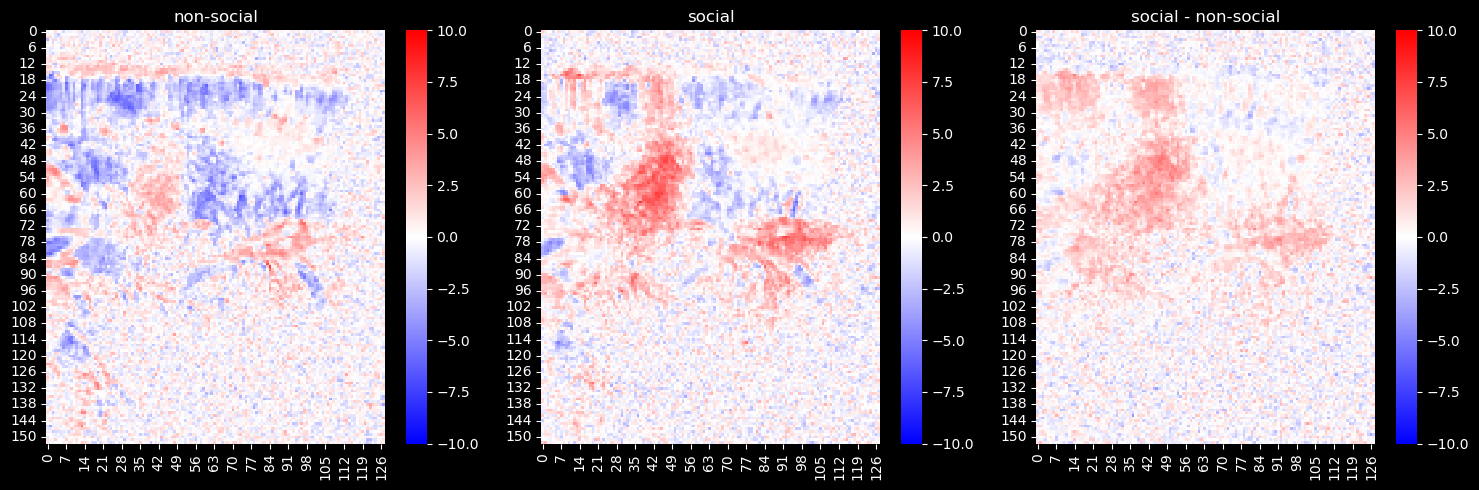

In [52]:
plot_contrasts(contrast_results, vmin=-10, vmax=10)

In [48]:
def get_trial_data(event_df, pixel_data, tr=1/2.5):
    offset_start = -5
    offset_end = 15

    onset_indices = event_df['nearest_index_onset'].values
    indices = [np.arange(i + offset_start, i + offset_end, step=tr) for i in onset_indices]

    slice_length = len(indices[0]) * pixel_data.shape[1]
    trial_data = np.full((len(event_df), slice_length), np.nan)

    for i, idx_range in enumerate(indices):
        valid_idx_range = (idx_range / tr).astype(int)
        valid_idx_range = valid_idx_range[(valid_idx_range >= 0) & (valid_idx_range < pixel_data.shape[0])]
        
        data = pixel_data[valid_idx_range, :].flatten()
        if len(data) > slice_length:
            data = data[:slice_length]
        elif len(data) < slice_length:
            data = np.pad(data, (0, slice_length - len(data)), 'constant', constant_values=np.nan)
        
        trial_data[i, :len(data)] = data

    return trial_data

def proc_pixel(pixel_data, event_df, tr=1/2.5):
    trial_data = get_trial_data(event_df, pixel_data, tr)
    normalized_data = []

    for trial_type in event_df['trial_type'].unique():
        data = trial_data[event_df['trial_type'] == trial_type]
        normalized_data.append(normalize_data(data))
    
    return normalized_data  # returns a list [reward_data_normalized, airpuff_data_normalized, idle_data_normalized]

/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Index.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  return bound(*args, **kwds)


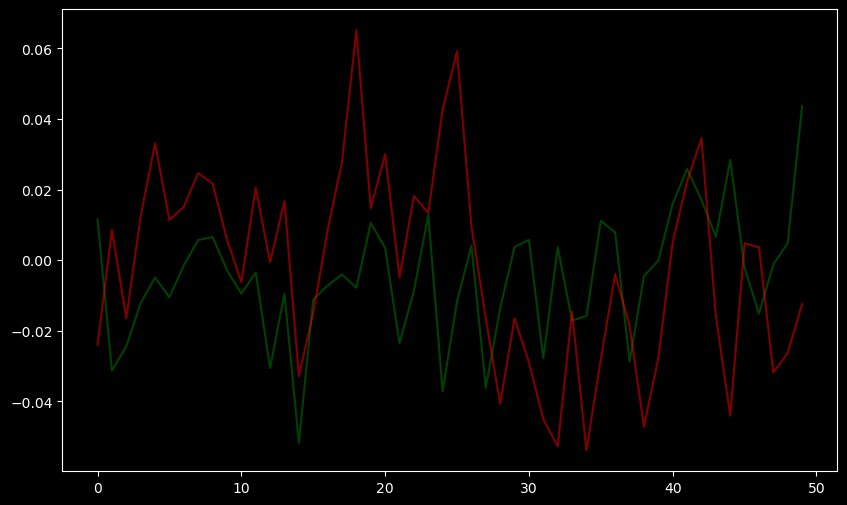

In [70]:
tr = 1 / 2.5
n_tr = brain_data.shape[-1]
frame_times = np.arange(n_tr) * tr

event_df2, event_binary_df = map_events_to_frame_times(event_df1, frame_times)

i, j = 60, 42
pixel_data = normalized_data_divide[i,0,j,:].reshape(-1,1)
# pixel_data = Y[i, :].reshape(-1, 1)  # Ensure pixel_data is 2D
normalized_data = proc_pixel(pixel_data, event_df2)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the three lines
plt.plot(np.nanmean(normalized_data[0], axis=0), label='Non-social', alpha=0.5, color='green')  
plt.plot(np.nanmean(normalized_data[1], axis=0), label='Social', alpha=0.5, color='red')
plt.show()

In [67]:
normalized_data[0].shape

(51, 50)

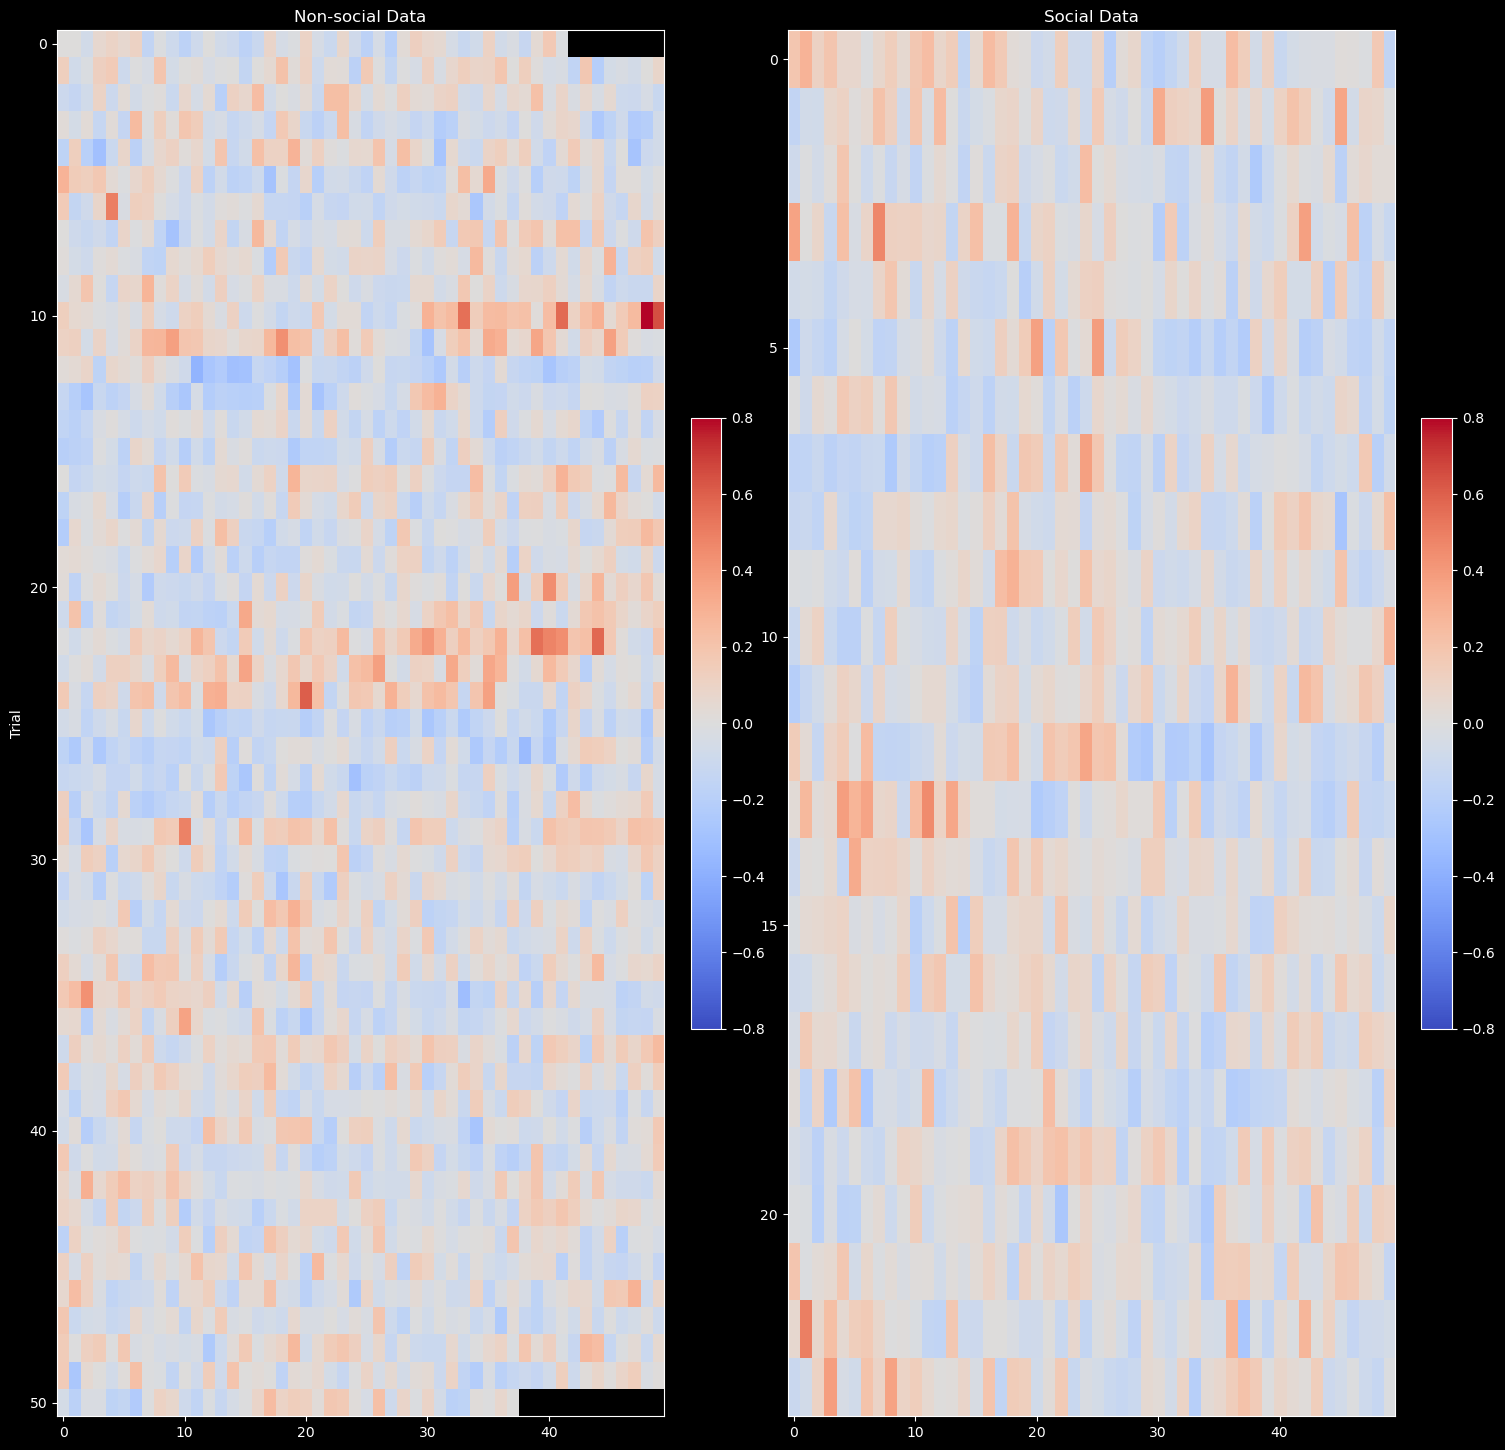

In [71]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 18))  # Adjust the figure size to accommodate three plots

# Use GridSpec to control the layout
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)  # Three equal-width plots

min_val = -0.8
max_val = 0.8
# First plot (reward_data)
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(normalized_data[0], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax0.set_title('Non-social Data')
ax0.set_ylabel('Trial')
# ax0.set_xticks([])  # Adjust or remove ticks as needed

# Second plot (airpuff_data)
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(normalized_data[1], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax1.set_title('Social Data')
# ax1.set_xticks([])  # Adjust or remove ticks as needed
# ax1.set_yticks([])


# Add colorbars (optional)
plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

plt.show()

In [62]:
import numpy as np
import pandas as pd

def normalize_time_series(ts, window_size):
    ts_series = pd.Series(ts)
    moving_avg = ts_series.rolling(window=window_size, min_periods=1).mean().values
    norm_ts_sub = ts - moving_avg
    norm_ts_div = norm_ts_sub / (moving_avg + np.finfo(float).eps)
    return norm_ts_sub, norm_ts_div

def apply_normalization(brain_data, window_size):
    normalized_data_subtract = np.zeros_like(brain_data)
    normalized_data_divide = np.zeros_like(brain_data)

    for i in range(brain_data.shape[0]):
        for j in range(brain_data.shape[2]):
            ts = brain_data[i, 0, j, :]
            norm_ts_sub, norm_ts_div = normalize_time_series(ts, window_size)
            normalized_data_subtract[i, 0, j, :] = norm_ts_sub
            normalized_data_divide[i, 0, j, :] = norm_ts_div

    return normalized_data_subtract, normalized_data_divide

window_size = 225 
normalized_data_subtract, normalized_data_divide = apply_normalization(brain_data, window_size)

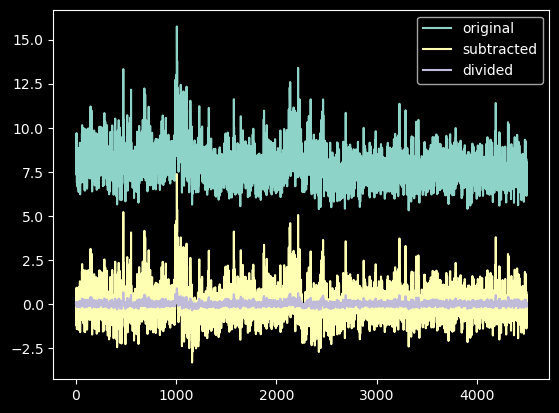

In [63]:
plt.plot(brain_data[60,0,42,:], label='original')
plt.plot(normalized_data_subtract[60,0,42,:], label='subtracted')
plt.plot(normalized_data_divide[60,0,42,:], label='divided')
plt.legend()
plt.show()

## Audio

In [73]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_socialvideo_data/'
brain_filename = 'Grouper_Marmoaudio_0227_2Dscan_2.nii'
event_filename = 'mldata.mat'
task_type = 'audio'

In [74]:
brain_data, event_mat = load_data(data_dir, brain_filename, event_filename, task_type)
condition, behave_codes, absolute_starttime = extract_event_info(event_mat, task_type)
event_df = create_design_matrix(condition, behave_codes, absolute_starttime, task_type)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 153, 4500)


In [75]:
event_df

,onset,trial_type,duration,end,raw_onset
0,4.292488,4,4,14.280081099997915,4.292488
1,22.511248,2,4,32.49933969999984,22.511248
2,40.730044,3,4,50.717223500003456,40.730044
3,54.941016,5,4,64.92890410000109,54.941016
4,70.170638,2,4,80.1584434000033,70.170638
...,...,...,...,...,...
109,1793.807342,7,4,1803.7941820999984,1793.807342
110,1808.018247,8,4,1818.0058933000037,1808.018247
111,1824.233134,1,4,1834.2206513999993,1824.233134
112,1838.444103,9,4,1848.4315229999993,1838.444103


In [76]:
event_df1 = event_df.copy()
for i, row in event_df.iterrows():
    if row["trial_type"] == "1" or row["trial_type"] == "9" or row["trial_type"] == "10":
        event_df1.at[i, "trial_type"] = "non-social"
    else:
        event_df1.at[i, "trial_type"] = "social"

In [77]:
event_df1

,onset,trial_type,duration,end,raw_onset
0,4.292488,social,4,14.280081099997915,4.292488
1,22.511248,social,4,32.49933969999984,22.511248
2,40.730044,social,4,50.717223500003456,40.730044
3,54.941016,social,4,64.92890410000109,54.941016
4,70.170638,social,4,80.1584434000033,70.170638
...,...,...,...,...,...
109,1793.807342,social,4,1803.7941820999984,1793.807342
110,1808.018247,social,4,1818.0058933000037,1808.018247
111,1824.233134,non-social,4,1834.2206513999993,1824.233134
112,1838.444103,non-social,4,1848.4315229999993,1838.444103


In [80]:
event_df2 = event_df1.dropna(subset=['onset'])

X = create_glm_design_matrix(brain_data, event_df2, tr=1/2.5, hrf_model='glover', drift_model='polynomial', drift_order=3)
contrast_results = run_glm_and_compute_contrasts(brain_data, X, task_type)

/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: end, raw_onset
  warnings.warn(


In [81]:
def plot_contrasts(contrast_results, shape=(128, 153), vmin=-15, vmax=15):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i, (key, value) in enumerate(contrast_results.items()):
        sns.heatmap(value.reshape(*shape).T, ax=axes[i], cmap="bwr", vmin=vmin, vmax=vmax)
        axes[i].set_title(key)

    plt.tight_layout()
    plt.show()

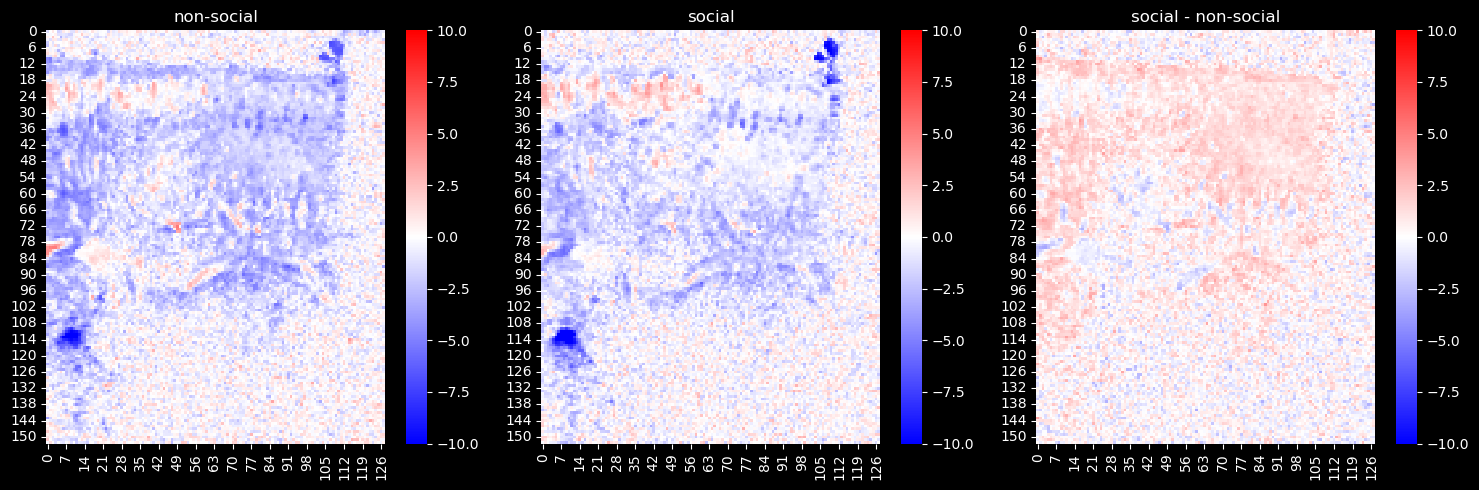

In [90]:
plot_contrasts(contrast_results, vmin=-10, vmax=10)

In [85]:
window_size = 225 
normalized_data_subtract, normalized_data_divide = apply_normalization(brain_data, window_size)

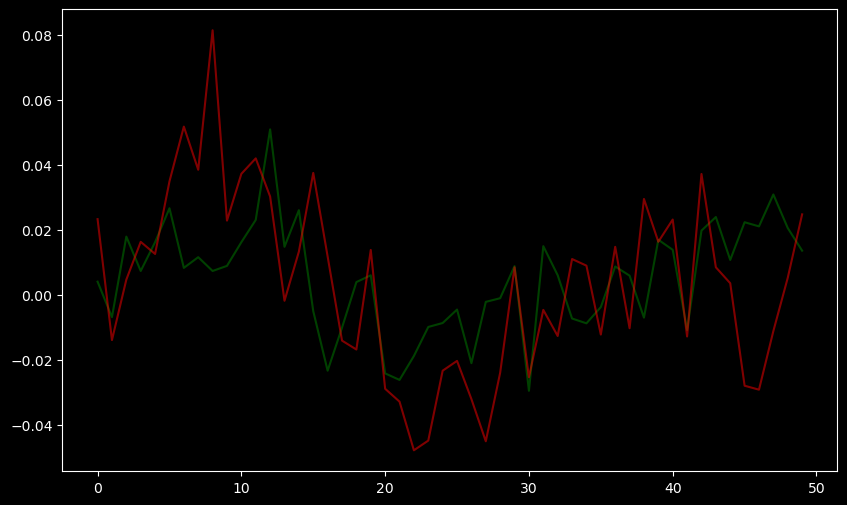

In [87]:
tr = 1 / 2.5
n_tr = brain_data.shape[-1]
frame_times = np.arange(n_tr) * tr

event_df2, event_binary_df = map_events_to_frame_times(event_df1, frame_times)

i, j = 24, 49
pixel_data = normalized_data_divide[i,0,j,:].reshape(-1,1)
# pixel_data = Y[i, :].reshape(-1, 1)  # Ensure pixel_data is 2D
normalized_data = proc_pixel(pixel_data, event_df2)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the three lines
plt.plot(np.nanmean(normalized_data[0], axis=0), label='Non-social', alpha=0.5, color='green')  
plt.plot(np.nanmean(normalized_data[1], axis=0), label='Social', alpha=0.5, color='red')
plt.show()

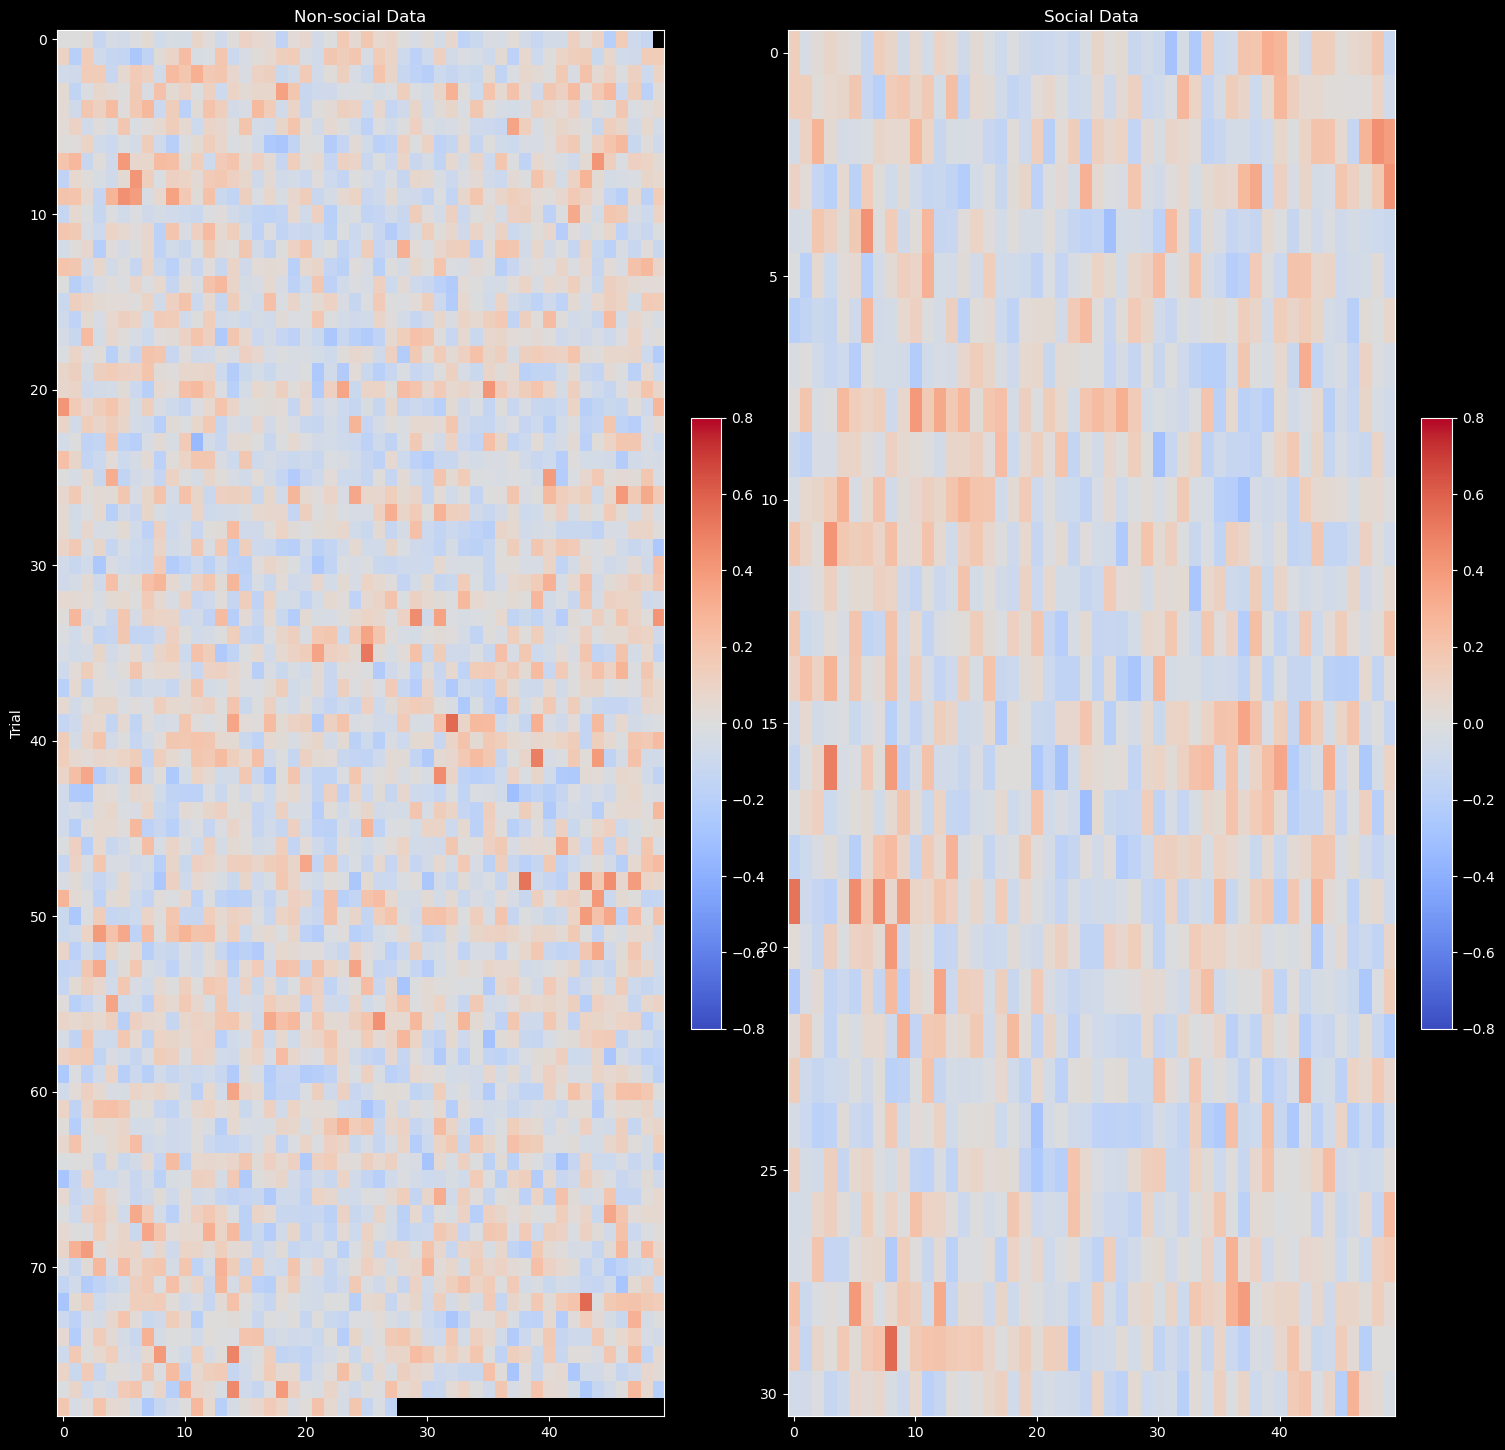

In [88]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 18))  # Adjust the figure size to accommodate three plots

# Use GridSpec to control the layout
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)  # Three equal-width plots

min_val = -0.8
max_val = 0.8
# First plot (reward_data)
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(normalized_data[0], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax0.set_title('Non-social Data')
ax0.set_ylabel('Trial')
# ax0.set_xticks([])  # Adjust or remove ticks as needed

# Second plot (airpuff_data)
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(normalized_data[1], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax1.set_title('Social Data')
# ax1.set_xticks([])  # Adjust or remove ticks as needed
# ax1.set_yticks([])


# Add colorbars (optional)
plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

plt.show()